In [37]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


In [38]:
# Load CSVs
train_labels = pd.read_csv('Dataset/B. RFMiD_Challenge_Dataset/B. RFMiD_Challenge_Dataset/2. Groundtruths/a. RFMiD_Training_Labels.csv')
val_labels = pd.read_csv('Dataset/B. RFMiD_Challenge_Dataset/B. RFMiD_Challenge_Dataset/2. Groundtruths/b. RFMiD_Validation_Labels.csv')
test_labels = pd.read_csv('Dataset/B. RFMiD_Challenge_Dataset/B. RFMiD_Challenge_Dataset/2. Groundtruths/c. RFMiD_Testing_Labels.csv')


In [39]:
# CLAHE preprocessing function
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Resize to match EfficientNetB0 expected size
    image = cv2.resize(image, (224, 224))

    # Apply CLAHE
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)

    return final / 255.0  # Normalize image to [0, 1]


In [66]:
# Data generator class with CLAHE and augmentation
class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataframe, image_dir, batch_size, augment=False, shuffle=True):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.augment = augment
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.dataframe))
        self.label_encoder = LabelEncoder()
        self.dataframe['Diagnosis'] = self.label_encoder.fit_transform(self.dataframe['Diagnosis'])

    def __len__(self):
        return int(np.floor(len(self.dataframe) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]
        batch_df = self.dataframe.iloc[batch_indexes]
    
        images = []  # Initialize as a list
        labels = []  # Initialize as a list
    
        for _, row in batch_df.iterrows():
            # Convert row['ID'] to a string before concatenating with ".png"
            img_path = os.path.join(self.image_dir, str(row['ID']) + ".png")  # Convert ID to string
            img = preprocess_image(img_path)  # Assuming preprocess_image is a function that loads and processes the image
    
            # Data augmentation
            if self.augment:
                if np.random.rand() < 0.5:
                    img = tf.image.random_flip_left_right(img)
                if np.random.rand() < 0.5:
                    img = tf.image.random_brightness(img, max_delta=0.1)
                if np.random.rand() < 0.5:
                    # Corrected zoom effect code here
                    scale_factor = np.random.uniform(0.9, 1.1)  # Random zoom factor
                    img_shape = tf.shape(img)[:2]  # Get the shape of the image (height, width)
    
                    # Apply scale factor and floor it correctly
                    new_height = tf.cast(tf.floor(tf.cast(img_shape[0], tf.float32) * scale_factor), tf.int32)
                    new_width = tf.cast(tf.floor(tf.cast(img_shape[1], tf.float32) * scale_factor), tf.int32)
    
                    new_size = tf.stack([new_height, new_width])  # Stack to create a tensor with shape [height, width]
    
                    img = tf.image.resize(img, new_size)  # Resize the image
                    img = tf.image.resize_with_crop_or_pad(img, target_height=224, target_width=224)  # Crop or pad
    
            images.append(img)  # Append to list
            labels.append(row['Diagnosis'])  # Assuming 'Diagnosis' is the correct label column
    
        images = np.array(images) / 255.0  # Normalize the images to [0, 1] range
        labels = np.array(labels)
    
        # Debug: Check unique labels
        print("Unique labels:", np.unique(labels))
    
        # Handle the case where there is only one class in the batch
        if len(np.unique(labels)) == 1:
            num_classes = 2  # Assume 2 classes if there is only one class present in this batch
        else:
            num_classes = len(np.unique(labels))
    
        # One-hot encoding of labels
        return images, tf.keras.utils.to_categorical(labels, num_classes=num_classes)


    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)  # Shuffle the dataset at the end of each epoch


In [67]:
# Now use the correct column name, for example 'Disease_Risk'
train_labels['Diagnosis'] = train_labels['Disease_Risk']  # Assigning 'Disease_Risk' to 'Diagnosis'
val_labels['Diagnosis'] = val_labels['Disease_Risk']
test_labels['Diagnosis'] = test_labels['Disease_Risk']

# Ensure the column 'Diagnosis' exists in the dataframe
if 'Diagnosis' not in train_labels.columns:
    raise KeyError("'Diagnosis' column not found in train_labels dataframe")
if 'Diagnosis' not in val_labels.columns:
    raise KeyError("'Diagnosis' column not found in val_labels dataframe")
if 'Diagnosis' not in test_labels.columns:
    raise KeyError("'Diagnosis' column not found in test_labels dataframe")


In [68]:
batch_size = 32

train_generator = CustomDataGenerator(
    dataframe=train_labels,
    image_dir="Dataset/B. RFMiD_Challenge_Dataset/B. RFMiD_Challenge_Dataset/1. Original Images/a. Training Set", # <-- update this
    batch_size=batch_size,
    augment=True
)

val_generator = CustomDataGenerator(
    dataframe=val_labels,
    image_dir="Dataset/B. RFMiD_Challenge_Dataset/B. RFMiD_Challenge_Dataset/1. Original Images/b. Validation Set", # <-- update this
    batch_size=batch_size,
    augment=False
)

test_generator = CustomDataGenerator(
    dataframe=test_labels,
    image_dir="Dataset/B. RFMiD_Challenge_Dataset/B. RFMiD_Challenge_Dataset/1. Original Images/c. Testing Set", # <-- update this
    batch_size=batch_size,
    augment=False
)


In [69]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(len(np.unique(train_labels['Diagnosis'])), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_18 (Rescaling)      │ (None, 224, 224, 3)       │               0 │ input_layer_9[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization_9               │ (None, 224, 224, 3)       │               7 │ rescaling_18[0][0]         │
│ (Normalization)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_19 (Rescaling)      │ (None, 224, 224, 3)       │               0 │ normalization_9[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv_pad (ZeroPadding2D) │ (None, 225, 225, 3)       │               0 │ rescaling_19[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 112, 112, 32)      │             864 │ stem_conv_pad[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 112, 112, 32)      │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 112, 112, 32)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 112, 112, 32)      │             288 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 112, 112, 32)      │             128 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 112, 112, 32)      │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 32)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 32)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)    │ (None, 1, 1, 8)           │             264 │ block1a_se_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_expand (Conv2D)    │ (None, 1, 1, 32)          │             28

 Total params: 4,706,469 (17.95 MB)

 Trainable params: 656,898 (2.51 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [70]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('efficientnetb0_best.keras', monitor='val_accuracy', save_best_only=True, mode='max')

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint]
)

D:\anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Unique labels: [0 1]
Unique labels: [1]
Epoch 1/20
Unique labels: [0 1]
 1/60 ━━━━━━━━━━━━━━━━━━━━ 16:03 16s/step - accuracy: 0.7812 - loss: 0.5933Unique labels: [0 1]
 2/60 ━━━━━━━━━━━━━━━━━━━━ 7:59 8s/step - accuracy: 0.7109 - loss: 0.9465  Unique labels: [0 1]
 3/60 ━━━━━━━━━━━━━━━━━━━━ 5:15 6s/step - accuracy: 0.6962 - loss: 1.0054Unique labels: [0 1]
 4/60 ━━━━━━━━━━━━━━━━━━━━ 4:23 5s/step - accuracy: 0.7077 - loss: 0.9890Unique labels: [0 1]
 5/60 ━━━━━━━━━━━━━━━━━━━━ 3:53 4s/step - accuracy: 0.7186 - loss: 0.9642Unique labels: [0 1]
 6/60 ━━━━━━━━━━━━━━━━━━━━ 3:34 4s/step - accuracy: 0.7299 - loss: 0.9374Unique labels: [0 1]
 7/60 ━━━━━━━━━━━━━━━━━━━━ 3:20 4s/step - accuracy: 0.7386 - loss: 0.9118Unique labels: [0 1]
 8/60 ━━━━━━━━━━━━━━━━━━━━ 3:10 4s/step - accuracy: 0.7468 - loss: 0.8858Unique labels: [0 1]
 9/60 ━━━━━━━━━━━━━━━━━━━━ 3:01 4s/step - accuracy: 0.7549 - loss: 0.8599Unique labels: [0 1]
10/60 ━━━━━━━━━━━━━━━━━━━━ 2:54 3s/step - accuracy: 0.7606 - loss: 0.8403Uniqu

In [71]:
# Unfreeze all layers for fine-tuning
for layer in model.layers:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

history_finetune = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stop]
)


Unique labels: [0 1]
Unique labels: [0 1]
Epoch 1/10
Unique labels: [0 1]
 1/60 ━━━━━━━━━━━━━━━━━━━━ 47:16 48s/step - accuracy: 0.0625 - loss: 3.7656Unique labels: [0 1]
 2/60 ━━━━━━━━━━━━━━━━━━━━ 4:37 5s/step - accuracy: 0.1094 - loss: 3.4506  Unique labels: [0 1]
 3/60 ━━━━━━━━━━━━━━━━━━━━ 4:04 4s/step - accuracy: 0.1354 - loss: 3.2323Unique labels: [0 1]
 4/60 ━━━━━━━━━━━━━━━━━━━━ 3:59 4s/step - accuracy: 0.1504 - loss: 3.0667Unique labels: [0 1]
 5/60 ━━━━━━━━━━━━━━━━━━━━ 3:55 4s/step - accuracy: 0.1553 - loss: 2.9322Unique labels: [0 1]
 6/60 ━━━━━━━━━━━━━━━━━━━━ 3:51 4s/step - accuracy: 0.1589 - loss: 2.8091Unique labels: [0 1]
 7/60 ━━━━━━━━━━━━━━━━━━━━ 3:45 4s/step - accuracy: 0.1649 - loss: 2.6943Unique labels: [0 1]
 8/60 ━━━━━━━━━━━━━━━━━━━━ 3:38 4s/step - accuracy: 0.1736 - loss: 2.5901Unique labels: [0 1]
 9/60 ━━━━━━━━━━━━━━━━━━━━ 3:32 4s/step - accuracy: 0.1844 - loss: 2.4945Unique labels: [0 1]
10/60 ━━━━━━━━━━━━━━━━━━━━ 3:27 4s/step - accuracy: 0.1978 - loss: 2.4067Uni

In [72]:
model.save('efficientnetb0_retinal_final.h5')

print("✅ Model training complete and saved!")


✅ Model training complete and saved!


In [73]:
# Smooth Curve Function
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points


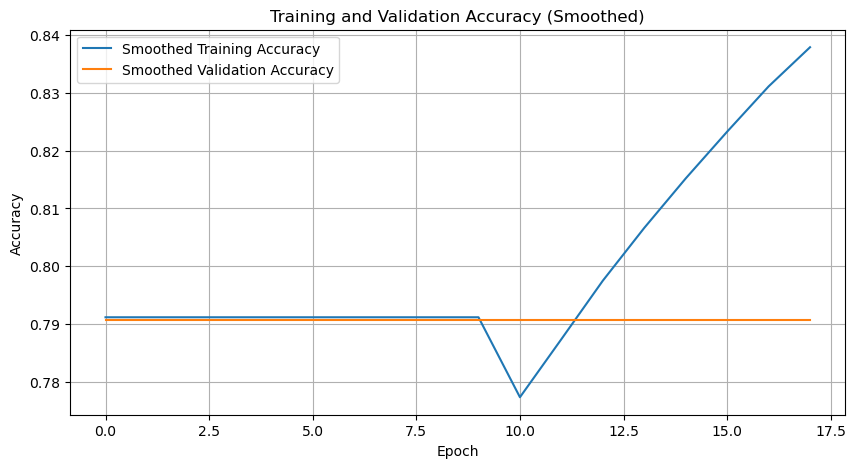

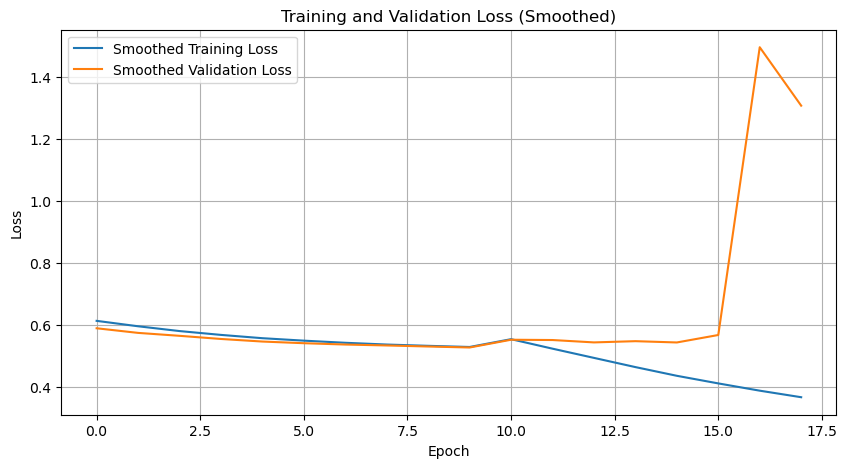

In [74]:
# Combine histories
def combine_histories(h1, h2):
    history = {}
    for k in h1.history.keys():
        history[k] = h1.history[k] + h2.history[k]
    return history

full_history = combine_histories(history, history_finetune)

# Smooth
smooth_acc = smooth_curve(full_history['accuracy'])
smooth_val_acc = smooth_curve(full_history['val_accuracy'])
smooth_loss = smooth_curve(full_history['loss'])
smooth_val_loss = smooth_curve(full_history['val_loss'])

# Plot
plt.figure(figsize=(10,5))
plt.plot(smooth_acc, label='Smoothed Training Accuracy')
plt.plot(smooth_val_acc, label='Smoothed Validation Accuracy')
plt.title('Training and Validation Accuracy (Smoothed)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(smooth_loss, label='Smoothed Training Loss')
plt.plot(smooth_val_loss, label='Smoothed Validation Loss')
plt.title('Training and Validation Loss (Smoothed)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [75]:
# Evaluate model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

Unique labels: [1]
Unique labels: [1]
Unique labels: [1]
 1/20 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 1.0000 - loss: 0.2368Unique labels: [1]
 2/20 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 1.0000 - loss: 0.2368Unique labels: [1]
 3/20 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 1.0000 - loss: 0.2368Unique labels: [1]
 4/20 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 1.0000 - loss: 0.2368Unique labels: [1]
 5/20 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 1.0000 - loss: 0.2368Unique labels: [1]
 6/20 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 1.0000 - loss: 0.2368Unique labels: [1]
 7/20 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 1.0000 - loss: 0.2368Unique labels: [0 1]
 8/20 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.9995 - loss: 0.2374Unique labels: [0 1]
 9/20 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.9961 - loss: 0.2419Unique labels: [0 1]
10/20 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.9918 - loss: 0.2476Unique labels: [0 1]
11/20 ━━━━━━━━━━━━━━━━━━━